In [2]:
%matplotlib inline


import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os 
from rasterio import open as r_open 
from rasterio.plot import show as r_show 
from subprocess import Popen
from rasterstats import zonal_stats


In [3]:
#working folder to Colombia
def wf(x):
    return '/Users/cecilywang/Downloads/EE508/Colombia/' + x
#biomodelos folder
def bf(x):
    return '/Users/cecilywang/Downloads/EE508/Data/Lab1/Lab1-4/BioModelos/' + x

# B) creating the planning unit files

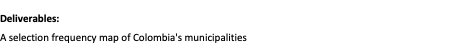


In [4]:
municipios_shp = gpd.read_file(wf('input/Lab2/Municipios.shp'))
municipios_shp


NOMBRE_ENT CATEGORIA DEPARTAMEN COD_DEPART COD_MUNICI  \
0                       POTOSÍ         M     NARIÑO         52        560   
1               PUERTO CAICEDO         M   PUTUMAYO         86        569   
2                      CÓRDOBA         M     NARIÑO         52        215   
3                      PUERRES         M     NARIÑO         52        573   
4                        ORITO         M   PUTUMAYO         86        320   
...                        ...       ...        ...        ...        ...   
1146  PANÁ-PANÁ (Campo Alegre)        CD    GUAINÍA         94        887   
1147  PANÁ-PANÁ (Campo Alegre)        CD    GUAINÍA         94        887   
1148                   LETICIA         M   AMAZONAS         91        001   
1149                    MARINO       NaN     MARINO        NaN        NaN   
1150                    MARINO       NaN     MARINO        NaN        NaN   

           AREA_KM                                  OBSERVACIO    PK_CUE  \
0       376.602234                                         NaN  501281.0   
1       926.232805                                         NaN  501283.0   
2       304.590581                                         NaN  501287.0   
3       350.147196                                         NaN  501293.0   
4      1936.372994                                         NaN  501295.0   
...            ...                                         ...       ...   
1146  10196.363739  En proceso de Aprobación. Sujeto a cambios  500771.0   
1147  10196.363739  En proceso de Aprobación. Sujeto a cambios  500771.0   
1148   6209.697256  En proceso de Aprobación. Sujeto a cambios  501248.0   
1149      0.000000                                         NaN       0.0   
1150      0.000000                                         NaN       0.0   

        DT        dt2      MUN  \
0     DTAO  ANDES OCC  52560.0   
1     DTAM   AMAZONIA  86569.0   
2     DTAO  ANDES OCC  52215.0   
3     DTAO  ANDES OCC  52573.0   
4     DTAM   AMAZONIA  86320.0   
...    ...        ...      ...   
1146  DTAM   AMAZONIA  94887.0   
1147  DTAM   AMAZONIA  94887.0   
1148  DTAM   AMAZONIA  91001.0   
1149  DTCA     CARIBE      NaN   
1150  DTPA   PACIFICO      NaN   

                                               geometry  
0     POLYGON ((-77.18681 0.63095, -77.37836 0.63707...  
1     POLYGON ((-76.46654 0.86688, -76.40921 0.86698...  
2     POLYGON ((-77.54163 0.89267, -77.54162 0.89265...  
3     POLYGON ((-77.15916 0.74383, -77.16463 0.72116...  
4     POLYGON ((-76.76607 0.79298, -76.76560 0.79262...  
...                                                 ...  
1146  POLYGON ((-68.17246 1.97236, -68.17386 1.97257...  
1147  POLYGON ((-68.17246 1.97236, -68.17219 1.97233...  
1148  POLYGON ((-69.71422 -3.00261, -69.71423 -3.002...  
1149  POLYGON ((-79.27778 16.16944, -79.27778 16.070...  
1150  POLYGON ((-77.87957 7.21123, -77.87939 7.21116...  

[1151 rows x 12 columns]

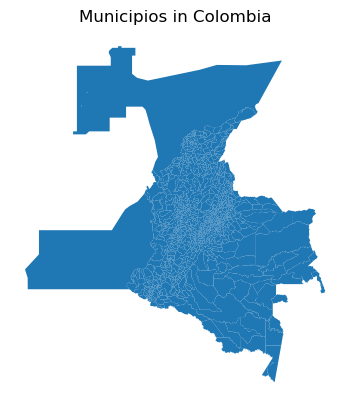

In [5]:
# Read the Municipios.shp file as a GeoDataFrame
mun = gpd.read_file(wf("input/Lab2/Municipios.shp"), encoding='utf-8')

# Plot the Municipios.shp layer
mun.plot()
plt.title("Municipios in Colombia")
plt.axis('off')
plt.show()

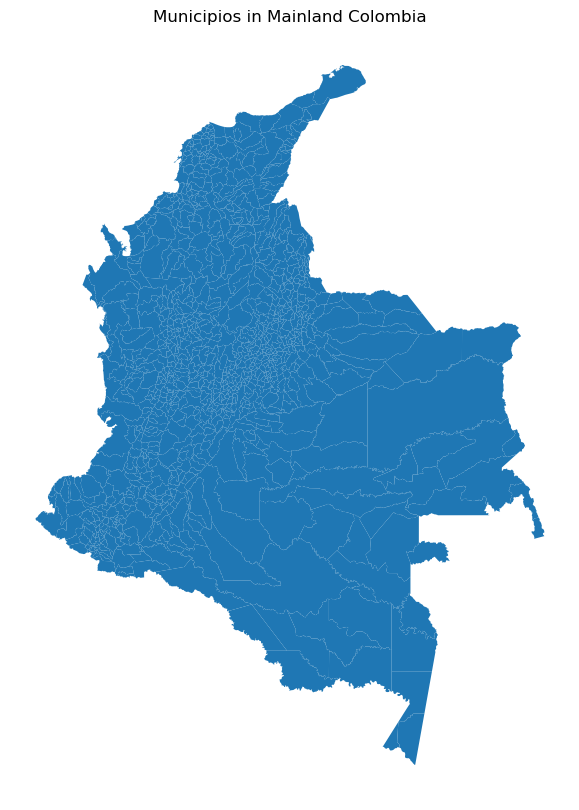

In [6]:
# Filter out unwanted rows for marine areas and islands
marine_filter = mun['NOMBRE_ENT'].eq('MARINO') | mun['COD_DEPART'].isnull()
islands_filter = mun['DEPARTAMEN'].str.contains('SAN ANDRÉS') | mun['COD_DEPART'].eq('88')

# Combine the filters to identify both marine areas and islands
unwanted_filter = marine_filter | islands_filter

# Use boolean indexing to remove unwanted rows
mun = mun[~unwanted_filter]

# Plot the filtered GeoDataFrame to visualize Colombia without islands and marine areas
mun.plot(figsize=(10, 10))
plt.title("Municipios in Mainland Colombia")
plt.axis('off')  # Turn off axis labels
plt.show()


In [7]:
# Dissolve the GeoDataFrame 'mun' by the 'MUN' column to remove duplicates
mun = mun.dissolve(by='MUN')

# Check the number of planning units (should be 1,120)
len(mun)


1120

In [8]:
# Create the 'id' index directly
mun.index = pd.Index(range(1, len(mun) + 1), name='id')
mun

geometry  \
id                                                        
1     POLYGON ((-75.66878 6.37300, -75.66802 6.37249...   
2     POLYGON ((-75.41551 5.90179, -75.41534 5.90193...   
3     POLYGON ((-76.01133 6.64633, -76.01142 6.64586...   
4     POLYGON ((-75.02849 6.41628, -75.02842 6.41628...   
5     POLYGON ((-75.67406 6.08290, -75.67384 6.08257...   
...                                                 ...   
1116  POLYGON ((-69.70679 1.11899, -69.70623 1.11884...   
1117  POLYGON ((-67.81400 5.34258, -67.81467 5.34316...   
1118  POLYGON ((-68.81353 6.17289, -68.81653 5.41894...   
1119  POLYGON ((-70.66411 5.38671, -70.65230 5.37409...   
1120  POLYGON ((-67.81400 5.34258, -67.81546 5.33997...   

                          NOMBRE_ENT CATEGORIA DEPARTAMEN COD_DEPART  \
id                                                                     
1                           MEDELLÍN         M  ANTIOQUIA         05   
2                          ABEJORRAL         M  ANTIOQUIA         05   
3                           ABRIAQUÍ         M  ANTIOQUIA         05   
4                         ALEJANDRÍA         M  ANTIOQUIA         05   
5                              AMAGÁ         M  ANTIOQUIA         05   
...                              ...       ...        ...        ...   
1116  YAVARATÉ  (Cor. Departamental)        CD     VAUPÉS         97   
1117                  PUERTO CARREÑO         M    VICHADA         99   
1118                    LA PRIMAVERA         M    VICHADA         99   
1119                   SANTA ROSALÍA         M    VICHADA         99   
1120                        CUMARIBO         M    VICHADA         99   

     COD_MUNICI       AREA_KM                                  OBSERVACIO  \
id                                                                          
1           001    372.897934                                        None   
2           002    510.593949                                        None   
3           004    292.848815                                        None   
4           021    132.584682                                        None   
5           030     82.870126                                        None   
...         ...           ...                                         ...   
1116        889   4666.385924  En proceso de Aprobación. Sujeto a cambios   
1117        001  12205.660436  En proceso de Aprobación. Sujeto a cambios   
1118        524  18371.827366  En proceso de Aprobación. Sujeto a cambios   
1119        624   3914.729536                                        None   
1120        773  65595.354596  En proceso de Aprobación. Sujeto a cambios   

        PK_CUE    DT        dt2  
id                               
1     502085.0  DTAO  ANDES OCC  
2     502382.0  DTAO  ANDES OCC  
3     502223.0  DTAO  ANDES OCC  
4     502108.0  DTAO  ANDES OCC  
5     501989.0  DTAO  ANDES OCC  
...        ...   ...        ...  
1116  501325.0  DTAM   AMAZONIA  
1117  502065.0  DTOR  ORINOQUIA  
1118  502033.0  DTOR  ORINOQUIA  
1119  501646.0  DTOR  ORINOQUIA  
1120  501728.0  DTOR  ORINOQUIA  

[1120 rows x 11 columns]

In [9]:
# Calculate the area of each municipality in square kilometers (km2)
mun['km2'] = mun['geometry'].to_crs(epsg=3395).area / 1e6  # Convert from square meters to square kilometers

# Create the 'cost' column that contains the area in km2 rounded to 2 decimal places
mun['cost'] = mun['km2'].round(2)

# Create the 'status' column, assuming all planning units start at status 0
mun['status'] = 0
#making sure the first cost column is correct value
mun

geometry  \
id                                                        
1     POLYGON ((-75.66878 6.37300, -75.66802 6.37249...   
2     POLYGON ((-75.41551 5.90179, -75.41534 5.90193...   
3     POLYGON ((-76.01133 6.64633, -76.01142 6.64586...   
4     POLYGON ((-75.02849 6.41628, -75.02842 6.41628...   
5     POLYGON ((-75.67406 6.08290, -75.67384 6.08257...   
...                                                 ...   
1116  POLYGON ((-69.70679 1.11899, -69.70623 1.11884...   
1117  POLYGON ((-67.81400 5.34258, -67.81467 5.34316...   
1118  POLYGON ((-68.81353 6.17289, -68.81653 5.41894...   
1119  POLYGON ((-70.66411 5.38671, -70.65230 5.37409...   
1120  POLYGON ((-67.81400 5.34258, -67.81546 5.33997...   

                          NOMBRE_ENT CATEGORIA DEPARTAMEN COD_DEPART  \
id                                                                     
1                           MEDELLÍN         M  ANTIOQUIA         05   
2                          ABEJORRAL         M  ANTIOQUIA         05   
3                           ABRIAQUÍ         M  ANTIOQUIA         05   
4                         ALEJANDRÍA         M  ANTIOQUIA         05   
5                              AMAGÁ         M  ANTIOQUIA         05   
...                              ...       ...        ...        ...   
1116  YAVARATÉ  (Cor. Departamental)        CD     VAUPÉS         97   
1117                  PUERTO CARREÑO         M    VICHADA         99   
1118                    LA PRIMAVERA         M    VICHADA         99   
1119                   SANTA ROSALÍA         M    VICHADA         99   
1120                        CUMARIBO         M    VICHADA         99   

     COD_MUNICI       AREA_KM                                  OBSERVACIO  \
id                                                                          
1           001    372.897934                                        None   
2           002    510.593949                                        None   
3           004    292.848815                                        None   
4           021    132.584682                                        None   
5           030     82.870126                                        None   
...         ...           ...                                         ...   
1116        889   4666.385924  En proceso de Aprobación. Sujeto a cambios   
1117        001  12205.660436  En proceso de Aprobación. Sujeto a cambios   
1118        524  18371.827366  En proceso de Aprobación. Sujeto a cambios   
1119        624   3914.729536                                        None   
1120        773  65595.354596  En proceso de Aprobación. Sujeto a cambios   

        PK_CUE    DT        dt2           km2      cost  status  
id                                                               
1     502085.0  DTAO  ANDES OCC    377.081913    377.08       0  
2     502382.0  DTAO  ANDES OCC    515.544383    515.54       0  
3     502223.0  DTAO  ANDES OCC    296.412574    296.41       0  
4     502108.0  DTAO  ANDES OCC    134.181736    134.18       0  
5     501989.0  DTAO  ANDES OCC     83.721968     83.72       0  
...        ...   ...        ...           ...       ...     ...  
1116  501325.0  DTAM   AMAZONIA   4638.317378   4638.32       0  
1117  502065.0  DTOR  ORINOQUIA  12199.913667  12199.91       0  
1118  502033.0  DTOR  ORINOQUIA  18430.466451  18430.47       0  
1119  501646.0  DTOR  ORINOQUIA   3930.069697   3930.07       0  
1120  501728.0  DTOR  ORINOQUIA  65529.778323  65529.78       0  

[1120 rows x 14 columns]

In [10]:
# Save the planning unit information to 'pu.dat' in the 'mun/input' folder
mun[['cost', 'status']].to_csv('/Users/cecilywang/Downloads/EE508/Colombia/mun/input/pu.dat')



In [1]:
with open(wf('/mun/input.dat')) as file:
    print(file.read())


NameError: name 'wf' is not defined

In [12]:
# Save 'mun' as a shapefile to 'pulayer.shp' in the 'mun/pulayer' folder
mun[['geometry']].to_file(wf('mun/pulayer/pulayer.shp'), index=True)


DriverError: /Users/cecilywang/Downloads/EE508/Colombia/mun/pulayer/pulayer.shp is not a directory.

In [13]:
mun_s = mun.copy()
mun_s = mun_s.to_crs(epsg=4326)
mun_s['geometry'] = mun_s['geometry'].simplify(0.005)


In [14]:
# Save 'mun_s' to the 'temp' folder
mun_s.to_file(wf('temp/pulayer_4326_simplified.shp'))


/Users/cecilywang/miniconda3/envs/ee508/lib/python3.11/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


<Axes: >

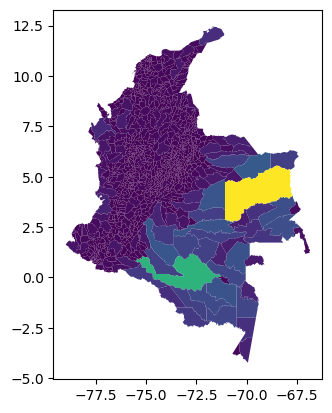

In [15]:
mun_s.plot('cost')

### Part c) create the species (conservation features)file

In [17]:

# Load the species data from 'species.csv'
sp = pd.read_csv(wf('input/Lab2/species.csv'), encoding='utf-8')



In [18]:
sp['id'] = range(1, len(sp) + 1)
sp['prop'] = 0.3
sp['spf'] = 1


In [19]:
sp = sp.set_index('id')

In [20]:
sp

name class category           km2  prop  spf
id                                                                   
1              Aburria aburri  bird       NT  1.392887e+05   0.3    1
2      Aglaiocercus coelestis  bird       LC  2.953912e+04   0.3    1
3              Akodon affinis  mamm       LC  4.219484e+04   0.3    1
4    Amazilia castaneiventris  bird       EN  1.593804e+04   0.3    1
5       Amazilia viridigaster  bird       LC  4.293576e+04   0.3    1
..                        ...   ...      ...           ...   ...  ...
234         Urochroa bougueri  bird       LC  4.020155e+04   0.3    1
235       Urosticte benjamini  bird       LC  1.737909e+04   0.3    1
236         Vampyrum spectrum  mamm       NT  5.278036e+06   0.3    1
237     Vermivora chrysoptera  bird       NT  4.556185e+06   0.3    1
238     Xenopipo flavicapilla  bird       VU  3.271874e+04   0.3    1

[238 rows x 6 columns]

In [21]:
#index=False to remove the column that starts with zero and just get our data that we are asking for 
sp[['prop', 'spf', 'name']].to_csv(wf('mun/input/spec.dat'))
print(sp[['prop', 'spf', 'name']])


     prop  spf                      name
id                                      
1     0.3    1            Aburria aburri
2     0.3    1    Aglaiocercus coelestis
3     0.3    1            Akodon affinis
4     0.3    1  Amazilia castaneiventris
5     0.3    1     Amazilia viridigaster
..    ...  ...                       ...
234   0.3    1         Urochroa bougueri
235   0.3    1       Urosticte benjamini
236   0.3    1         Vampyrum spectrum
237   0.3    1     Vermivora chrysoptera
238   0.3    1     Xenopipo flavicapilla

[238 rows x 3 columns]


### Part D) create the planning unit vs species file

In [22]:
# Create an empty DataFrame with columns: 'pu' and 'species'

pu_x_sp = pd.DataFrame(
    index=mun.index.rename('pu'),
    columns=sp.index.rename('species')
)


In [24]:
from rasterstats import zonal_stats

# Initialize the columns in pu_x_sp with NaN values
pu_x_sp.loc[:, :] = None

# Iterate through species data
for sp_id, sp_data in sp.iloc[:].iterrows():
    print(f"Processing species {sp_id}: {sp_data['name']}")

    # Modify the species name by replacing spaces with underscores
    species_name = sp_data['name'].replace(' ', '_')

    # Define the path to your species distribution raster
    species_raster_path = f"/Users/cecilywang/Downloads/EE508/Data/Lab1/Lab1-4/Biomodelos/{species_name}_coarse.tif"

    # Use zonal_stats to calculate the sum of values within each planning unit
    stats = zonal_stats(
        wf('temp/pulayer_4326_simplified.shp'),
        species_raster_path,
        stats="sum",
    )

    # Assign the results to the corresponding column in pu_x_sp
    pu_x_sp[sp_id] = [s['sum'] for s in stats]

Processing species 1: Aburria aburri
Processing species 2: Aglaiocercus coelestis
Processing species 3: Akodon affinis
Processing species 4: Amazilia castaneiventris
Processing species 5: Amazilia viridigaster
Processing species 6: Amazona farinosa
Processing species 7: Andigena hypoglauca
Processing species 8: Andigena laminirostris
Processing species 9: Anisognathus melanogenys
Processing species 10: Anisognathus notabilis
Processing species 11: Anthocephala floriceps
Processing species 12: Aotus lemurinus
Processing species 13: Ara ambiguus
Processing species 14: Ara militaris
Processing species 15: Ateles belzebuth
Processing species 16: Ateles fusciceps
Processing species 17: Atlapetes albofrenatus
Processing species 18: Atlapetes fuscoolivaceus
Processing species 19: Atlapetes melanocephalus
Processing species 20: Atlapetes rufinucha
Processing species 21: Aulacorhynchus sulcatus
Processing species 22: Bangsia aureocincta
Processing species 23: Bangsia edwardsi
Processing species

In [25]:
pu_x_sp

species        1    2          3    4            5            6         7    \
pu                                                                            
1        39.889238  0.0  46.333353  0.0    47.000000    43.777989  0.000000   
2        56.220415  0.0  57.220259  0.0    60.554219    61.332088  0.111038   
3        33.555565  0.0  39.000000  0.0    39.000000    29.554098  0.000000   
4        16.000000  0.0  12.889373  0.0    16.000000    16.000000  0.000000   
5         6.443925  0.0   8.221821  0.0     8.777514     8.555292  0.000000   
...            ...  ...        ...  ...          ...          ...       ...   
1116      0.000000  0.0   0.000000  0.0     0.000000    14.001420  0.000000   
1117      0.000000  0.0   0.000000  0.0     0.000000  1077.784210  0.000000   
1118      0.000000  0.0   0.000000  0.0   179.446081   706.220052  0.000000   
1119      0.000000  0.0   0.000000  0.0     0.000000     0.000000  0.000000   
1120      0.000000  0.0   0.000000  0.0  6070.793973  5561.207330  0.000000   

species  8    9    10   ...        229        230         231          232  \
pu                      ...                                                  
1        0.0  0.0  0.0  ...  38.889001   0.000000    0.000000    22.111855   
2        0.0  0.0  0.0  ...  48.442217   0.000000    0.000000    61.443245   
3        0.0  0.0  0.0  ...  32.110230   0.000000    0.000000    34.555510   
4        0.0  0.0  0.0  ...  12.889446  15.333314    0.000000    16.000000   
5        0.0  0.0  0.0  ...   1.777132   0.000000    0.000000     6.443971   
...      ...  ...  ...  ...        ...        ...         ...          ...   
1116     0.0  0.0  0.0  ...   0.000000   0.000000  341.782137   297.667712   
1117     0.0  0.0  0.0  ...   0.000000   0.000000    0.000000    18.556153   
1118     0.0  0.0  0.0  ...   0.000000   0.000000    0.000000   539.222603   
1119     0.0  0.0  0.0  ...   0.000000   0.000000    0.000000     0.000045   
1120     0.0  0.0  0.0  ...   0.000000   0.000000    8.110973  3076.888872   

species        233  234       235          236        237        238  
pu                                                                    
1        46.666640  0.0  0.000000     0.000000  47.000000  46.555529  
2        57.331343  0.0  0.000000     0.000000  61.777159  51.220140  
3        39.000000  0.0  2.778252     0.000000  39.000000  38.222269  
4        15.555655  0.0  0.000000     0.000000  16.000000  14.222614  
5         7.999408  0.0  0.000000     0.000000   9.000000   4.777277  
...            ...  ...       ...          ...        ...        ...  
1116      0.000000  0.0  0.000000     0.000000   0.000000   0.000000  
1117      0.000000  0.0  0.000000  1590.000000   0.000000   0.000000  
1118      0.000000  0.0  0.000000  1831.993232   0.000000   0.000000  
1119      0.000000  0.0  0.000000    15.331817   0.000000   0.000000  
1120      0.000000  0.0  0.000000  6114.986197   0.000000   0.000000  

[1120 rows x 238 columns]

In [26]:
mun

geometry  \
id                                                        
1     POLYGON ((-75.66878 6.37300, -75.66802 6.37249...   
2     POLYGON ((-75.41551 5.90179, -75.41534 5.90193...   
3     POLYGON ((-76.01133 6.64633, -76.01142 6.64586...   
4     POLYGON ((-75.02849 6.41628, -75.02842 6.41628...   
5     POLYGON ((-75.67406 6.08290, -75.67384 6.08257...   
...                                                 ...   
1116  POLYGON ((-69.70679 1.11899, -69.70623 1.11884...   
1117  POLYGON ((-67.81400 5.34258, -67.81467 5.34316...   
1118  POLYGON ((-68.81353 6.17289, -68.81653 5.41894...   
1119  POLYGON ((-70.66411 5.38671, -70.65230 5.37409...   
1120  POLYGON ((-67.81400 5.34258, -67.81546 5.33997...   

                          NOMBRE_ENT CATEGORIA DEPARTAMEN COD_DEPART  \
id                                                                     
1                           MEDELLÍN         M  ANTIOQUIA         05   
2                          ABEJORRAL         M  ANTIOQUIA         05   
3                           ABRIAQUÍ         M  ANTIOQUIA         05   
4                         ALEJANDRÍA         M  ANTIOQUIA         05   
5                              AMAGÁ         M  ANTIOQUIA         05   
...                              ...       ...        ...        ...   
1116  YAVARATÉ  (Cor. Departamental)        CD     VAUPÉS         97   
1117                  PUERTO CARREÑO         M    VICHADA         99   
1118                    LA PRIMAVERA         M    VICHADA         99   
1119                   SANTA ROSALÍA         M    VICHADA         99   
1120                        CUMARIBO         M    VICHADA         99   

     COD_MUNICI       AREA_KM                                  OBSERVACIO  \
id                                                                          
1           001    372.897934                                        None   
2           002    510.593949                                        None   
3           004    292.848815                                        None   
4           021    132.584682                                        None   
5           030     82.870126                                        None   
...         ...           ...                                         ...   
1116        889   4666.385924  En proceso de Aprobación. Sujeto a cambios   
1117        001  12205.660436  En proceso de Aprobación. Sujeto a cambios   
1118        524  18371.827366  En proceso de Aprobación. Sujeto a cambios   
1119        624   3914.729536                                        None   
1120        773  65595.354596  En proceso de Aprobación. Sujeto a cambios   

        PK_CUE    DT        dt2           km2      cost  status  
id                                                               
1     502085.0  DTAO  ANDES OCC    377.081913    377.08       0  
2     502382.0  DTAO  ANDES OCC    515.544383    515.54       0  
3     502223.0  DTAO  ANDES OCC    296.412574    296.41       0  
4     502108.0  DTAO  ANDES OCC    134.181736    134.18       0  
5     501989.0  DTAO  ANDES OCC     83.721968     83.72       0  
...        ...   ...        ...           ...       ...     ...  
1116  501325.0  DTAM   AMAZONIA   4638.317378   4638.32       0  
1117  502065.0  DTOR  ORINOQUIA  12199.913667  12199.91       0  
1118  502033.0  DTOR  ORINOQUIA  18430.466451  18430.47       0  
1119  501646.0  DTOR  ORINOQUIA   3930.069697   3930.07       0  
1120  501728.0  DTOR  ORINOQUIA  65529.778323  65529.78       0  

[1120 rows x 14 columns]

/Users/cecilywang/miniconda3/envs/ee508/lib/python3.11/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


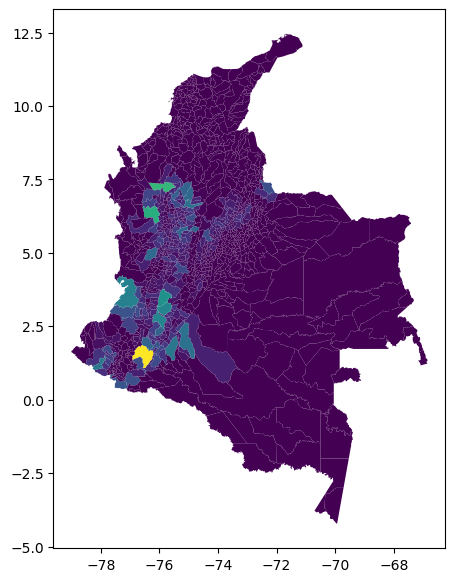

In [27]:
# Map the result

mun.join(pu_x_sp).plot(1, figsize=(7, 7))

# Save the results to a temporary CSV file
pu_x_sp.to_csv(wf('temp/pu_x_sp.csv'), index = False)

# Rename the index column to 'species' when reading the CSV file
pu_x_sp.columns = pu_x_sp.columns.rename('species')

In [28]:
puvspr = pu_x_sp.stack()


In [29]:
puvspr = pu_x_sp.stack().rename('amount').reset_index()


In [30]:
# Reorder columns in the desired order
puvspr = puvspr[['species', 'pu', 'amount']]

# Round the 'amount' column to one decimal place
puvspr['amount'] = puvspr['amount'].round(1)

puvspr = puvspr[puvspr['amount'] != 0]

# Save the DataFrame to 'mun/input/puvspr.dat'
puvspr.to_csv(wf('mun/input/puvspr.dat'), index=False)



### Part E create the boundary file

In [31]:
from matplotlib.colors import LinearSegmentedColormap

CMAP_DICT = {
    'red': [(0.0, 1.0, 1.0), (1.0, 0.0, 0.0)],
    'green': [(0.0, 1.0, 1.0), (1.0, 0.6, 0.6)],
    'blue': [(0.0, 1.0, 1.0), (1.0, 0.2, 0.2)],
}

my_cmap = LinearSegmentedColormap('', CMAP_DICT)

In [32]:
# Reproject to EPSG:21818
mun = mun.to_crs(epsg=21818)


In [33]:
bound_list = []
from itertools import combinations

# Iterate through all combinations of planning unit pairs
for id1, id2 in combinations(mun.index, 2):
    geom1 = mun.loc[id1, 'geometry']
    geom2 = mun.loc[id2, 'geometry']

    # Check if the geometries intersect
    if geom1.intersects(geom2):
        shared_boundary = geom1.intersection(geom2)

        # Check if the intersection is not empty and has a length
        if not shared_boundary.is_empty and shared_boundary.length > 0:
            # Append information to the list
            bound_list.append([id1, id2, shared_boundary.length])


In [34]:
bound = pd.DataFrame(bound_list, columns=['id', 'id2', 'boundary']).set_index('id')
bound['boundary'] = bound['boundary'].round(0)
bound

id2  boundary
id                  
1        8    4111.0
1       19   22094.0
1       41    2819.0
1       44   12398.0
1       47    5443.0
...    ...       ...
1117  1118   83831.0
1117  1120  226886.0
1118  1119   76242.0
1118  1120  416795.0
1119  1120  200597.0

[3201 rows x 2 columns]

In [35]:
bound.to_csv(wf('mun/input/bound.dat'))



### Part F
(need to run ./marxan on terminal first

In [36]:
def run_marxan(folder):
    import os 
    marxan_command = './marxan'
    os.chdir(folder)
    return Popen(marxan_command).wait()

run_marxan(wf('mun'))


        Marxan v 4.0.6 

   Spatial Prioritization via Annealing

   Coded by Ian Ball, modified by Matthew Watts
   Written by Ian Ball and Hugh Possingham

   Marxan website

https://marxansolutions.org/


Entering in the data files 
   There are 1120 Planning units.
  1120 Planning Unit names read in 
  238 species read in 
  3201 connections entered 
58241 conservation values counted, 266560 big matrix size, 21.8491% density of matrix 
Time passed so far is 0 secs 

Pre-processing Section. 
5 species are already adequately represented.
Running multithreaded over number of threads: 8
Running multithreaded over number of threads: 8
Runs will be printed as they complete, and may not be in order due to parallelisation.

Run 6: Using Calculated Tinit = 1.64837e+08 Tcool = 0.99985
Run 6 Init: Value 1.82142e+08 Cost 674977 PUs 582 Connection 4.37689e+07 Missing 8 Shortfall 243.56 Penalty 6.39098e+06 MPM 0
Run 6 ThermalAnnealing: Value 8.79403e+06 Cost 1.07029e+06 PUs 938 Connection 1.9309

0

/Users/cecilywang/miniconda3/envs/ee508/lib/python3.11/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


Text(0.5, 1.0, 'Selection Frequency')

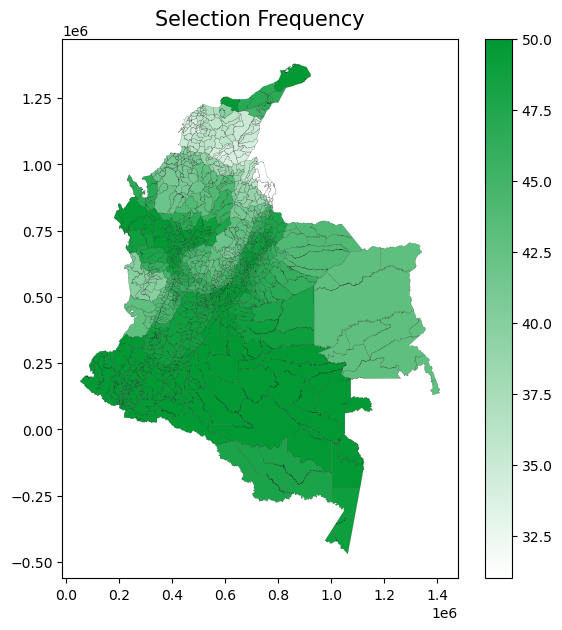

In [37]:
# Load the results
sol = pd.read_csv(wf('mun/output/output_ssoln.csv')).set_index('planning_unit')

# Create a map of the best solution
fig, ax = plt.subplots(figsize=(7, 7))
mun.join(sol).plot(
    'number',
    ax=ax,
    cmap=my_cmap,
    edgecolor='black',
    linewidth=0.1,
    legend=True
)
ax.set_title('Selection Frequency', fontsize=15, pad=10)


In [38]:


def change_marxan_parameters(filepath, change_dict):
    """
    Function to change the parameters in a Marxan parameter file

    Parameters
    ----------
    filepath : str
        Complete path of the parameter file. Usually ends with 'input.dat')
    change_dict : dict
        Dictionary of parameter values to be changed
        Example: {'BLM':0.1,'NUMREPS':100}
    """

    import os
    import re

    # Check if configuration file exists
    if not os.path.exists(filepath):
        print(filepath + ' not found')

    # Read configuration file
    with open(filepath) as file:
        old_text = file.read()

    # Copy the text, keep the old one
    new_text = old_text

    # Loop through each dictionary item
    for key, value in change_dict.items():
        # Define REGEX search pattern string
        search_regex = '\n' + key.upper() + ' +[0-9A-Za-z. -]+\n'

        # If the parameter can be found, print warning and skip to next item
        if re.search(search_regex, new_text) is None:
            print('Parameter ' + key + ' not found')
            continue

        # Define replacement string
        if type(value) == float and value < 0.001:
            value = '{0:.10f}'.format(value)
        replace_str = '\n' + key.upper() + ' ' + str(value) + '\n'

        # Replace strings
        new_text = re.sub(search_regex, replace_str, new_text)

    # If a change has been made, write the file
    if new_text != old_text:
        with open(filepath, 'w') as file:
            file.write(new_text)
            print('Saved new parameters to ' + filepath.split('/')[-1])


1e-05
Saved new parameters to input.dat
        Marxan v 4.0.6 

   Spatial Prioritization via Annealing

   Coded by Ian Ball, modified by Matthew Watts
   Written by Ian Ball and Hugh Possingham

   Marxan website

https://marxansolutions.org/


Entering in the data files 
   There are 1120 Planning units.
  1120 Planning Unit names read in 
  238 species read in 
  3201 connections entered 
58241 conservation values counted, 266560 big matrix size, 21.8491% density of matrix 
Time passed so far is 0 secs 

Pre-processing Section. 
5 species are already adequately represented.
Running multithreaded over number of threads: 8
Running multithreaded over number of threads: 8
Runs will be printed as they complete, and may not be in order due to parallelisation.

Run 7: Using Calculated Tinit = 856652 Tcool = 0.999847
Run 7 Init: Value 734999 Cost 707267 PUs 564 Connection 4.07865e+07 Missing 9 Shortfall 489.94 Penalty 27323.7 MPM 0
Run 7 ThermalAnnealing: Value 305881 Cost 298716 PUs 404 

/Users/cecilywang/miniconda3/envs/ee508/lib/python3.11/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


0.0001
Saved new parameters to input.dat
        Marxan v 4.0.6 

   Spatial Prioritization via Annealing

   Coded by Ian Ball, modified by Matthew Watts
   Written by Ian Ball and Hugh Possingham

   Marxan website

https://marxansolutions.org/


Entering in the data files 
   There are 1120 Planning units.
  1120 Planning Unit names read in 
  238 species read in 
  3201 connections entered 
58241 conservation values counted, 266560 big matrix size, 21.8491% density of matrix 
Time passed so far is 0 secs 

Pre-processing Section. 
5 species are already adequately represented.
Running multithreaded over number of threads: 8
Running multithreaded over number of threads: 8
Runs will be printed as they complete, and may not be in order due to parallelisation.

Run 1: Using Calculated Tinit = 853571 Tcool = 0.999826
Run 1 Init: Value 561621 Cost 531680 PUs 555 Connection 4.19335e+07 Missing 13 Shortfall 453.69 Penalty 25747 MPM 0
Run 1 ThermalAnnealing: Value 314289 Cost 304864 PUs 397 

/Users/cecilywang/miniconda3/envs/ee508/lib/python3.11/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


0.001
Saved new parameters to input.dat
        Marxan v 4.0.6 

   Spatial Prioritization via Annealing

   Coded by Ian Ball, modified by Matthew Watts
   Written by Ian Ball and Hugh Possingham

   Marxan website

https://marxansolutions.org/


Entering in the data files 
   There are 1120 Planning units.
  1120 Planning Unit names read in 
  238 species read in 
  3201 connections entered 
58241 conservation values counted, 266560 big matrix size, 21.8491% density of matrix 
Time passed so far is 0 secs 

Pre-processing Section. 
5 species are already adequately represented.
Running multithreaded over number of threads: 8
Running multithreaded over number of threads: 8
Runs will be printed as they complete, and may not be in order due to parallelisation.

Run 4: Using Calculated Tinit = 922436 Tcool = 0.999822
Run 4 Init: Value 648457 Cost 582294 PUs 582 Connection 4.1893e+07 Missing 11 Shortfall 306.51 Penalty 24270.1 MPM 0
Run 4 ThermalAnnealing: Value 329310 Cost 303828 PUs 413 

/Users/cecilywang/miniconda3/envs/ee508/lib/python3.11/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


0.01
Saved new parameters to input.dat
        Marxan v 4.0.6 

   Spatial Prioritization via Annealing

   Coded by Ian Ball, modified by Matthew Watts
   Written by Ian Ball and Hugh Possingham

   Marxan website

https://marxansolutions.org/


Entering in the data files 
   There are 1120 Planning units.
  1120 Planning Unit names read in 
  238 species read in 
  3201 connections entered 
58241 conservation values counted, 266560 big matrix size, 21.8491% density of matrix 
Time passed so far is 0 secs 

Pre-processing Section. 
5 species are already adequately represented.
Running multithreaded over number of threads: 8
Running multithreaded over number of threads: 8
Runs will be printed as they complete, and may not be in order due to parallelisation.

Run 5: Using Calculated Tinit = 1.32004e+06 Tcool = 0.999812
Run 5 Init: Value 1.10392e+06 Cost 630323 PUs 578 Connection 4.22095e+07 Missing 14 Shortfall 460.73 Penalty 51503.2 MPM 0
Run 5 ThermalAnnealing: Value 410952 Cost 30608

/Users/cecilywang/miniconda3/envs/ee508/lib/python3.11/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


0.1
Saved new parameters to input.dat
        Marxan v 4.0.6 

   Spatial Prioritization via Annealing

   Coded by Ian Ball, modified by Matthew Watts
   Written by Ian Ball and Hugh Possingham

   Marxan website

https://marxansolutions.org/


Entering in the data files 
   There are 1120 Planning units.
  1120 Planning Unit names read in 
  238 species read in 
  3201 connections entered 
58241 conservation values counted, 266560 big matrix size, 21.8491% density of matrix 
Time passed so far is 0 secs 

Pre-processing Section. 
5 species are already adequately represented.
Running multithreaded over number of threads: 8
Running multithreaded over number of threads: 8
Runs will be printed as they complete, and may not be in order due to parallelisation.

Run 5: Using Calculated Tinit = 4.92399e+06 Tcool = 0.999842
Run 5 Init: Value 5.13307e+06 Cost 630323 PUs 578 Connection 4.22095e+07 Missing 14 Shortfall 460.73 Penalty 281793 MPM 0
Run 5 ThermalAnnealing: Value 1.04858e+06 Cost 52

/Users/cecilywang/miniconda3/envs/ee508/lib/python3.11/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


1
Saved new parameters to input.dat
        Marxan v 4.0.6 

   Spatial Prioritization via Annealing

   Coded by Ian Ball, modified by Matthew Watts
   Written by Ian Ball and Hugh Possingham

   Marxan website

https://marxansolutions.org/


Entering in the data files 
   There are 1120 Planning units.
  1120 Planning Unit names read in 
  238 species read in 
  3201 connections entered 
58241 conservation values counted, 266560 big matrix size, 21.8491% density of matrix 
Time passed so far is 0 secs 

Pre-processing Section. 
5 species are already adequately represented.
Running multithreaded over number of threads: 8
Running multithreaded over number of threads: 8
Runs will be printed as they complete, and may not be in order due to parallelisation.

Run 7: Using Calculated Tinit = 4.19902e+07 Tcool = 0.999832
Run 7 Init: Value 4.39716e+07 Cost 707267 PUs 564 Connection 4.07865e+07 Missing 9 Shortfall 489.94 Penalty 2.47785e+06 MPM 0
Run 7 ThermalAnnealing: Value 3.42146e+06 Cost 

/Users/cecilywang/miniconda3/envs/ee508/lib/python3.11/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


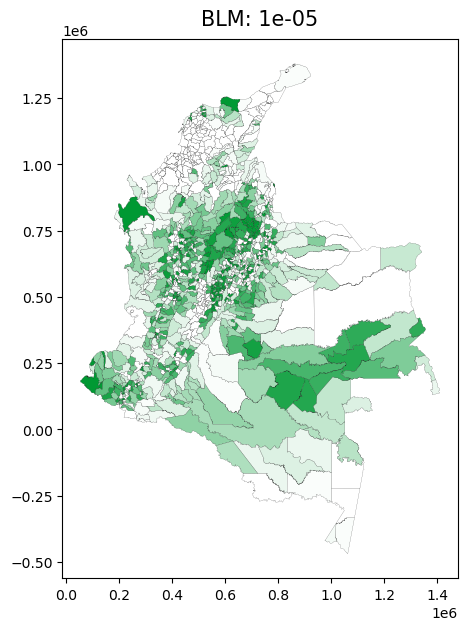

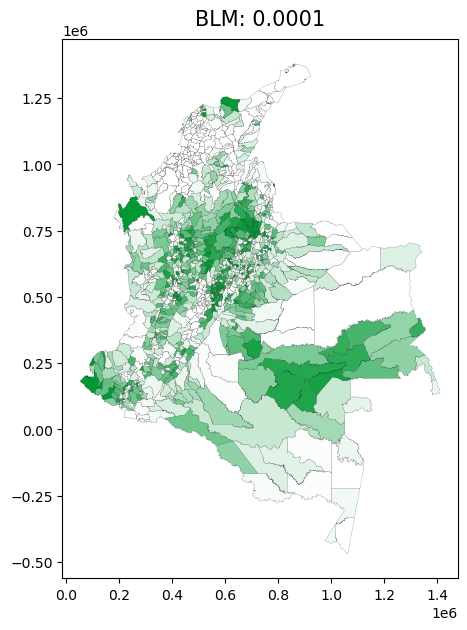

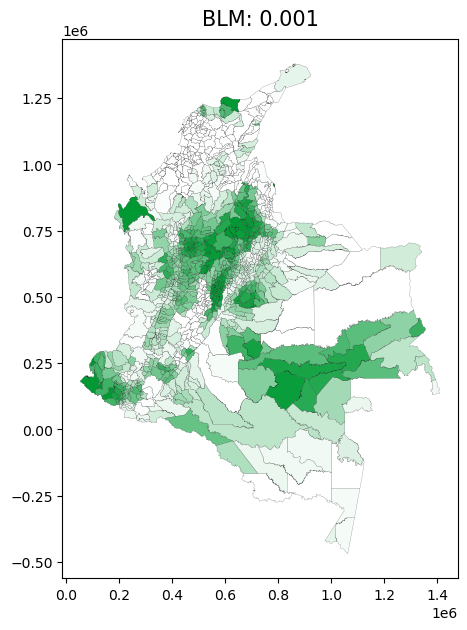

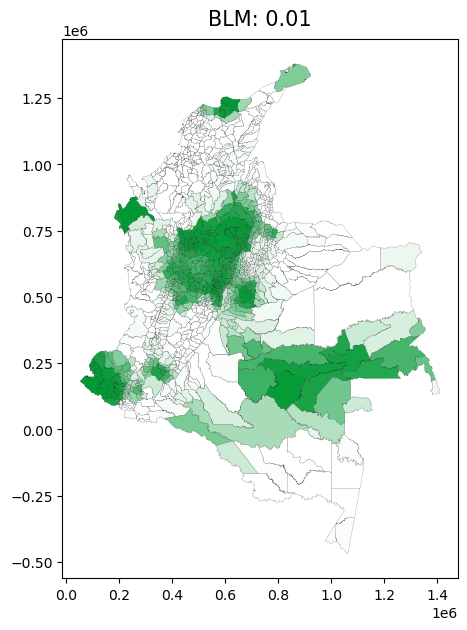

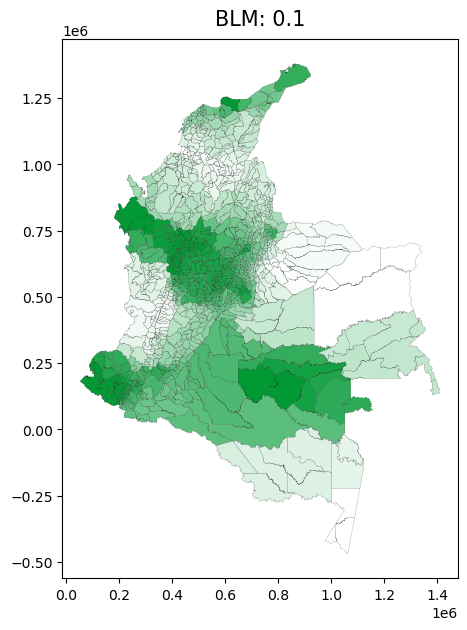

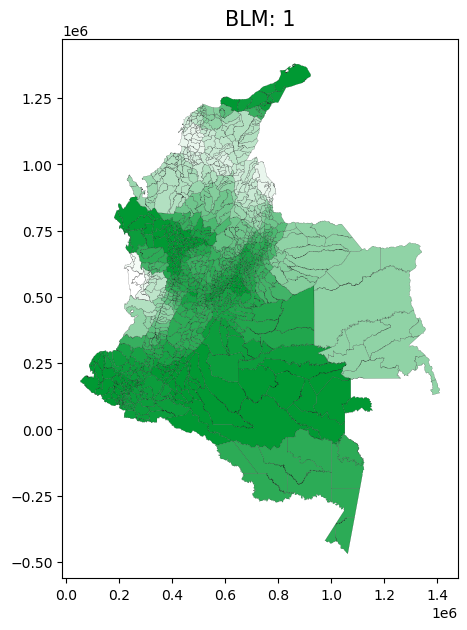

In [39]:
for blm_exp in range(-5, 1):

    blm = 10 ** blm_exp
    print(blm)
    change_marxan_parameters(
        wf('mun/input.dat'), {'BLM': blm, 'NUMREPS': 50}
    )
    run_marxan(wf('mun'))
    sol = pd.read_csv(wf('mun/output/output_ssoln.csv')).set_index('planning_unit')
    fig, ax = plt.subplots(figsize=(7, 7))
    mun.join(sol).plot(
        'number',
        ax=ax,
        cmap=my_cmap,
        edgecolor='black',
        linewidth=0.1,
    )
    ax.set_title('BLM: ' + str(blm), fontsize=15, pad=10)


### First Selection Frequency Map (BLM = 0.001)

0.001
Saved new parameters to input.dat
        Marxan v 4.0.6 

   Spatial Prioritization via Annealing

   Coded by Ian Ball, modified by Matthew Watts
   Written by Ian Ball and Hugh Possingham

   Marxan website

https://marxansolutions.org/


Entering in the data files 
   There are 1120 Planning units.
  1120 Planning Unit names read in 
  238 species read in 
  3201 connections entered 
58241 conservation values counted, 266560 big matrix size, 21.8491% density of matrix 
Time passed so far is 0 secs 

Pre-processing Section. 
5 species are already adequately represented.
Running multithreaded over number of threads: 8
Running multithreaded over number of threads: 8
Runs will be printed as they complete, and may not be in order due to parallelisation.

Run 4: Using Calculated Tinit = 922436 Tcool = 0.999822
Run 4 Init: Value 648457 Cost 582294 PUs 582 Connection 4.1893e+07 Missing 11 Shortfall 306.51 Penalty 24270.1 MPM 0
Run 4 ThermalAnnealing: Value 329310 Cost 303828 PUs 413 

/Users/cecilywang/miniconda3/envs/ee508/lib/python3.11/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


Text(0.5, 1.0, 'Selection Frequency Map of Colombia BLM: 0.001 ')

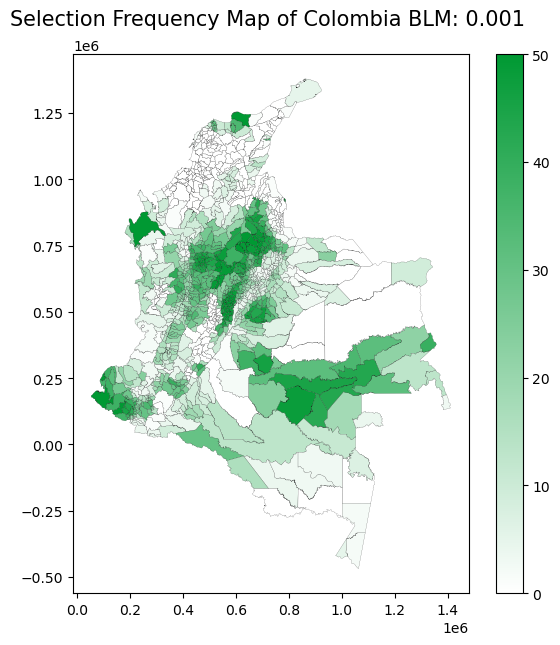

In [40]:


blm = .001
print(blm)
change_marxan_parameters(
    wf('mun/input.dat'), {'BLM': blm, 'NUMREPS': 50}
    )
run_marxan(wf('mun'))
sol = pd.read_csv(wf('mun/output/output_ssoln.csv')).set_index('planning_unit')
fig, ax = plt.subplots(figsize=(7, 7))
mun.join(sol).plot(
    'number',
    ax=ax,
    cmap=my_cmap,
    edgecolor='black',
    linewidth=0.1,
    legend=True

    )
ax.set_title('Selection Frequency Map of Colombia BLM: 0.001 ', fontsize=15, pad=10)


#filename = '/Volumes/Class_Folders/ee_508/Students/cecilyw/Deliverables/L2/2_selection_frequency_colombia.png'
#plt.savefig(filename,bbox_inches='tight', dpi=150)


### part G

In [43]:

travel_time_raster_path = '/Volumes/Class_Folders/ee_508/Class_Share/Data/Lab2/accessibility_to_cities_col.tif' 
municipality = gpd.read_file(wf('temp/pulayer_4326_simplified.shp'))

# Calculate the mean travel time for each municipality
stats = zonal_stats(municipality, travel_time_raster_path, nodata=-9999, stats='mean')
municipality['mean_travel_time'] = [s['mean'] for s in stats]
#cost = aread * traveltime**-.5
municipality['cost'] = municipality['km2'] * (municipality['mean_travel_time'] ** (-0.5))

In [44]:
municipality.set_index('id')

NOMBRE_ENT CATEGORIA DEPARTAMEN COD_DEPART  \
id                                                                     
1                           MEDELLÍN         M  ANTIOQUIA         05   
2                          ABEJORRAL         M  ANTIOQUIA         05   
3                           ABRIAQUÍ         M  ANTIOQUIA         05   
4                         ALEJANDRÍA         M  ANTIOQUIA         05   
5                              AMAGÁ         M  ANTIOQUIA         05   
...                              ...       ...        ...        ...   
1116  YAVARATÉ  (Cor. Departamental)        CD     VAUPÉS         97   
1117                  PUERTO CARREÑO         M    VICHADA         99   
1118                    LA PRIMAVERA         M    VICHADA         99   
1119                   SANTA ROSALÍA         M    VICHADA         99   
1120                        CUMARIBO         M    VICHADA         99   

     COD_MUNICI       AREA_KM                                  OBSERVACIO  \
id                                                                          
1           001    372.897934                                         NaN   
2           002    510.593949                                         NaN   
3           004    292.848815                                         NaN   
4           021    132.584682                                         NaN   
5           030     82.870126                                         NaN   
...         ...           ...                                         ...   
1116        889   4666.385924  En proceso de Aprobación. Sujeto a cambios   
1117        001  12205.660436  En proceso de Aprobación. Sujeto a cambios   
1118        524  18371.827366  En proceso de Aprobación. Sujeto a cambios   
1119        624   3914.729536                                         NaN   
1120        773  65595.354596  En proceso de Aprobación. Sujeto a cambios   

        PK_CUE    DT        dt2           km2         cost  status  \
id                                                                   
1     502085.0  DTAO  ANDES OCC    377.081913   126.981669       0   
2     502382.0  DTAO  ANDES OCC    515.544383    62.359320       0   
3     502223.0  DTAO  ANDES OCC    296.412574    15.013138       0   
4     502108.0  DTAO  ANDES OCC    134.181736    14.524342       0   
5     501989.0  DTAO  ANDES OCC     83.721968    18.260079       0   
...        ...   ...        ...           ...          ...     ...   
1116  501325.0  DTAM   AMAZONIA   4638.317378    73.380053       0   
1117  502065.0  DTOR  ORINOQUIA  12199.913667   592.880248       0   
1118  502033.0  DTOR  ORINOQUIA  18430.466451   678.330489       0   
1119  501646.0  DTOR  ORINOQUIA   3930.069697   167.256270       0   
1120  501728.0  DTOR  ORINOQUIA  65529.778323  1725.300801       0   

                                               geometry  mean_travel_time  
id                                                                         
1     POLYGON ((-75.66878 6.37300, -75.65153 6.33244...          8.818391  
2     POLYGON ((-75.42988 5.90222, -75.38049 5.88250...         68.348562  
3     POLYGON ((-76.01133 6.64633, -76.01649 6.57556...        389.807580  
4     POLYGON ((-75.02849 6.41628, -75.00680 6.38811...         85.348101  
5     POLYGON ((-75.67406 6.08290, -75.67173 6.05488...         21.021978  
...                                                 ...               ...  
1116  POLYGON ((-69.72216 1.10883, -69.70121 1.11640...       3995.442478  
1117  POLYGON ((-67.81400 5.34258, -67.84896 5.34902...        423.427979  
1118  POLYGON ((-68.81353 6.17289, -68.81653 5.41894...        738.227090  
1119  POLYGON ((-70.66411 5.38671, -70.19585 4.88450...        552.122811  
1120  POLYGON ((-67.81400 5.34258, -67.84768 5.30787...       1442.606052  

[1120 rows x 15 columns]

In [45]:
# Save the planning unit information to 'pu.dat' in the 'mun/input' folder
municipality[['id', 'cost', 'status']].to_csv(('/Users/cecilywang/Downloads/EE508/Colombia/mun/input/pu.dat'), index=False)

In [46]:
with open(wf('/mun/input.dat')) as file:
    print(file.read())

This file generated by marxan.net
emailto: m.watts@uq.edu.au

General Parameters
VERSION 0.1
BLM 0.001
PROP  0.5
RANDSEED -1
BESTSCORE  10
NUMREPS 50

Annealing Parameters
NUMITNS 1000000
STARTTEMP -1
COOLFAC  6
NUMTEMP 100000

Cost Threshold
COSTTHRESH  0
THRESHPEN1  14
THRESHPEN2  1

Input Files
INPUTDIR input
SPECNAME spec.dat
PUNAME pu.dat
PUVSPRNAME puvspr.dat

Save Files
SCENNAME output
SAVERUN 3
SAVEBEST 3
SAVESUMMARY 3
SAVESCEN 2
SAVETARGMET 3
SAVESUMSOLN 3
SAVESOLUTIONSMATRIX 3
SAVELOG 2
OUTPUTDIR output

Program control.
RUNMODE 1
MISSLEVEL  1
ITIMPTYPE 0
HEURTYPE -1
CLUMPTYPE 0
VERBOSITY 3

BOUNDNAME bound.dat



/Users/cecilywang/miniconda3/envs/ee508/lib/python3.11/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


<Axes: >

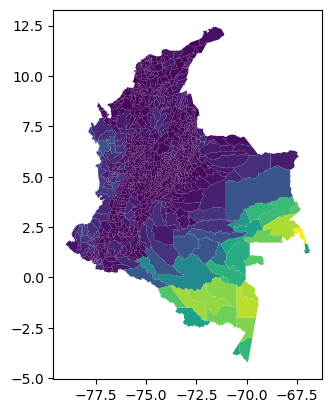

In [53]:
municipality.plot('mean_travel_time')

/Users/cecilywang/miniconda3/envs/ee508/lib/python3.11/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


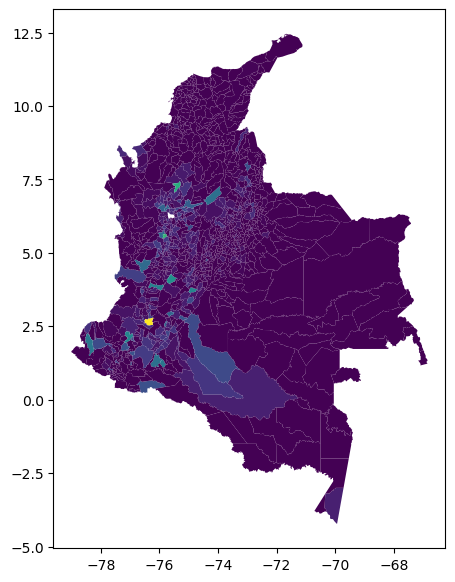

In [47]:
municipality.join(pu_x_sp).plot(1, figsize=(7, 7))

# Save the results to a temporary CSV file
pu_x_sp.to_csv(wf('temp/pu_x_sp.csv'), index = False)

# Rename the index column to 'species' when reading the CSV file
pu_x_sp.columns = pu_x_sp.columns.rename('species')

In [56]:
municipality = municipality.set_index('id')

1e-05
Saved new parameters to input.dat
        Marxan v 4.0.6 

   Spatial Prioritization via Annealing

   Coded by Ian Ball, modified by Matthew Watts
   Written by Ian Ball and Hugh Possingham

   Marxan website

https://marxansolutions.org/


Entering in the data files 
   There are 1120 Planning units.
  1120 Planning Unit names read in 
  238 species read in 
  3201 connections entered 
58241 conservation values counted, 266560 big matrix size, 21.8491% density of matrix 
Time passed so far is 0 secs 

Pre-processing Section. 
5 species are already adequately represented.
Running multithreaded over number of threads: 8
Running multithreaded over number of threads: 8
Runs will be printed as they complete, and may not be in order due to parallelisation.

Run 7: Using Calculated Tinit = 18986.1 Tcool = 0.99983
Run 7 Init: Value 36072.8 Cost 34184.4 PUs 564 Connection 4.07865e+07 Missing 9 Shortfall 489.94 Penalty 1480.5 MPM 0
Run 7 ThermalAnnealing: Value 12965.3 Cost 12671.5 PUs 2

/Users/cecilywang/miniconda3/envs/ee508/lib/python3.11/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


0.0001
Saved new parameters to input.dat
        Marxan v 4.0.6 

   Spatial Prioritization via Annealing

   Coded by Ian Ball, modified by Matthew Watts
   Written by Ian Ball and Hugh Possingham

   Marxan website

https://marxansolutions.org/


Entering in the data files 
   There are 1120 Planning units.
  1120 Planning Unit names read in 
  238 species read in 
  3201 connections entered 
58241 conservation values counted, 266560 big matrix size, 21.8491% density of matrix 
Time passed so far is 0 secs 

Pre-processing Section. 
5 species are already adequately represented.
Running multithreaded over number of threads: 8
Running multithreaded over number of threads: 8
Runs will be printed as they complete, and may not be in order due to parallelisation.

Run 4: Using Calculated Tinit = 23197.2 Tcool = 0.999847
Run 4 Init: Value 37752.5 Cost 32120.3 PUs 582 Connection 4.1893e+07 Missing 11 Shortfall 306.51 Penalty 1442.86 MPM 0
Run 4 ThermalAnnealing: Value 14852.7 Cost 13101.2 PU

/Users/cecilywang/miniconda3/envs/ee508/lib/python3.11/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


0.001
Saved new parameters to input.dat
        Marxan v 4.0.6 

   Spatial Prioritization via Annealing

   Coded by Ian Ball, modified by Matthew Watts
   Written by Ian Ball and Hugh Possingham

   Marxan website

https://marxansolutions.org/


Entering in the data files 
   There are 1120 Planning units.
  1120 Planning Unit names read in 
  238 species read in 
  3201 connections entered 
58241 conservation values counted, 266560 big matrix size, 21.8491% density of matrix 
Time passed so far is 0 secs 

Pre-processing Section. 
5 species are already adequately represented.
Running multithreaded over number of threads: 8
Running multithreaded over number of threads: 8
Runs will be printed as they complete, and may not be in order due to parallelisation.

Run 7: Using Calculated Tinit = 62155.3 Tcool = 0.999836
Run 7 Init: Value 78875.2 Cost 34184.4 PUs 564 Connection 4.07865e+07 Missing 9 Shortfall 489.94 Penalty 3904.3 MPM 0
Run 7 ThermalAnnealing: Value 25266.9 Cost 14540.5 PUs 

/Users/cecilywang/miniconda3/envs/ee508/lib/python3.11/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


0.01
Saved new parameters to input.dat


KeyboardInterrupt: 

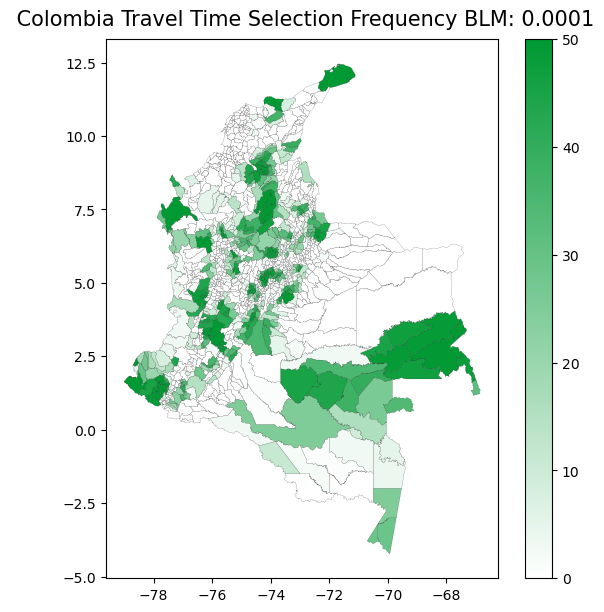

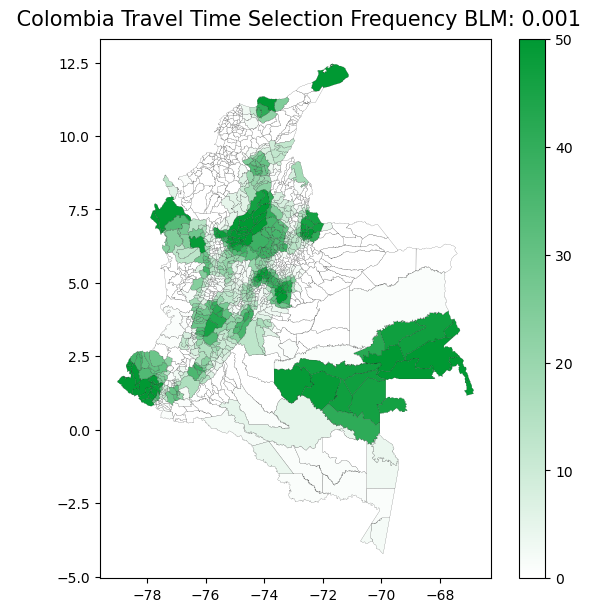

In [57]:
for blm_mult in range(-5, 1):

    blm = 10 ** blm_mult
    print(blm)
    change_marxan_parameters(
        wf('mun/input.dat'), {'BLM': blm, 'NUMREPS': 50}
    )
    run_marxan(wf('mun'))
    sol = pd.read_csv(wf('mun/output/output_ssoln.csv')).set_index('planning_unit')
    fig, ax = plt.subplots(figsize=(7, 7))
    municipality.join(sol).plot(
        'number',
        ax=ax,
        cmap=my_cmap,
        edgecolor='black',
        linewidth=0.1,
        legend=True
    )
    ax.set_title(' Colombia Travel Time Selection Frequency BLM: ' + str(blm), fontsize=15, pad=10)
#filename = '/Volumes/Class_Folders/ee_508/Students/cecilyw/Deliverables/L2/2_selection_frequency_colombia_traveltime.png'
#plt.savefig(filename,bbox_inches='tight', dpi=150)

Saved new parameters to input.dat
        Marxan v 4.0.6 

   Spatial Prioritization via Annealing

   Coded by Ian Ball, modified by Matthew Watts
   Written by Ian Ball and Hugh Possingham

   Marxan website

https://marxansolutions.org/


Entering in the data files 
   There are 1120 Planning units.
  1120 Planning Unit names read in 
  238 species read in 
  3201 connections entered 
58241 conservation values counted, 266560 big matrix size, 21.8491% density of matrix 
Time passed so far is 0 secs 

Pre-processing Section. 
5 species are already adequately represented.
Running multithreaded over number of threads: 8
Running multithreaded over number of threads: 8
Runs will be printed as they complete, and may not be in order due to parallelisation.

Run 6: Using Calculated Tinit = 62721.4 Tcool = 0.999848
Run 6 Init: Value 80394.4 Cost 34099.7 PUs 582 Connection 4.37689e+07 Missing 8 Shortfall 243.56 Penalty 2525.82 MPM 0
Run 6 ThermalAnnealing: Value 24452.2 Cost 14481.6 PUs 289 C

/Users/cecilywang/miniconda3/envs/ee508/lib/python3.11/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


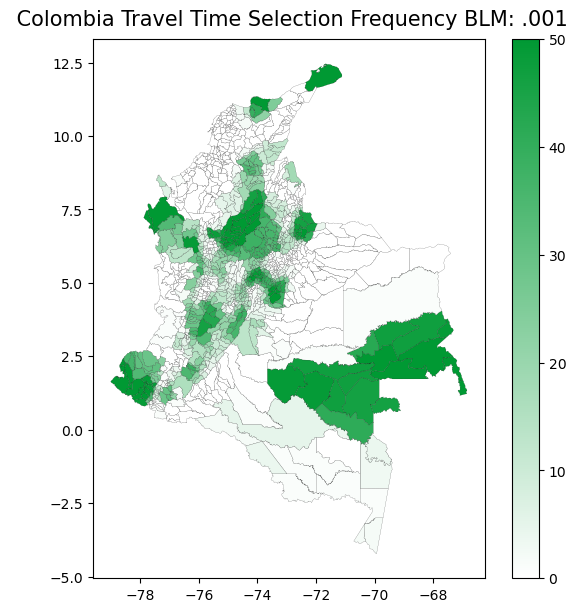

In [60]:

   
change_marxan_parameters(
        wf('mun/input.dat'), {'BLM': .001, 'NUMREPS': 50}
    )
run_marxan(wf('mun'))
sol = pd.read_csv(wf('mun/output/output_ssoln.csv')).set_index('planning_unit')
fig, ax = plt.subplots(figsize=(7, 7))
municipality.join(sol).plot(
        'number',
        ax=ax,
        cmap=my_cmap,
        edgecolor='black',
        linewidth=0.1,
        legend=True
    )
ax.set_title(' Colombia Travel Time Selection Frequency BLM: .001', fontsize=15, pad=10)
filename = '/Volumes/Class_Folders/ee_508/Students/cecilyw/Deliverables/L2/2_selection_frequency_colombia_traveltime.png'
plt.savefig(filename,bbox_inches='tight', dpi=150)

# Hexagons as planning unit, and still use proxy travel time

### Note that you still need to calculate the hexagon areas and boundaries. Don't forget to work in the appropriate projections. You don't need to simplify the polygons, as hexagons are already simple. Find a good BLM. Save a high-resolution version of the selection frequency map. Make sure to add a meaningful title that includes the BLM you have chosen.

In [44]:
#loading in the colombia hexagons
hexagon_layer_path = '/Volumes/Class_Folders/ee_508/Class_Share/Data/Lab2/colombia_hexagons.shp'
hexagons = gpd.read_file(hexagon_layer_path)

In [45]:
#calculating the area and changing the projection
hexagons['km2'] = hexagons.geometry.to_crs({'init': 'epsg:3395'}).area / 1e6

/Users/cecilywang/miniconda3/envs/ee508/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [54]:
hexagons.plot()

<Axes: >

In [46]:
zs = zonal_stats(
    hexagons, 
    travel_time_raster_path, 
    stats = 'mean', 
    all_touched = True, 
    no_data = -9999,
)

In [48]:
travel_t= pd.DataFrame(zs)
travel_t= acc.rename(columns = {'mean': 'traveltime'})
travel_t
#traveltime shouldnt be negative

traveltime
0     -861.841317
1     -455.062271
2       71.127630
3     -212.830904
4    -3543.504049
...           ...
1105  3687.428571
1106  2759.503686
1107  3206.340879
1108  4179.989501
1109  4778.774194

[1110 rows x 1 columns]

In [50]:
#creating the 'id' starting at 1 for the index of hexagons
hexagons.index = pd.Index(range(1, len(hexagons) + 1), name='id')


In [51]:
hexagons

left    bottom      right       top  \
id                                               
1    -79.163382  1.320001 -78.782330  1.650001   
2    -79.163382  1.650001 -78.782330  1.980001   
3    -78.877593  1.155001 -78.496542  1.485001   
4    -78.877593  1.485001 -78.496542  1.815001   
5    -78.877593  1.815001 -78.496542  2.145001   
...         ...       ...        ...       ...   
1106 -67.446052  3.465002 -67.065001  3.795002   
1107 -67.160264  0.990000 -66.779213  1.320001   
1108 -67.160264  1.320001 -66.779213  1.650001   
1109 -67.160264  1.650001 -66.779213  1.980001   
1110 -67.160264  1.980001 -66.779213  2.310001   

                                               geometry          km2  
id                                                                    
1     MULTIPOLYGON (((-78.95875 1.60097, -78.95875 1...   220.695542  
2     MULTIPOLYGON (((-78.78764 1.80930, -78.78764 1...   190.672199  
3     MULTIPOLYGON (((-78.55988 1.21029, -78.56026 1...   541.273556  
4     MULTIPOLYGON (((-78.70431 1.77986, -78.70431 1...  1093.261210  
5     MULTIPOLYGON (((-78.77069 1.81958, -78.77069 1...   353.361168  
...                                                 ...          ...  
1106  MULTIPOLYGON (((-67.44490 3.63200, -67.44046 3...     0.402726  
1107  POLYGON ((-66.87768 1.32000, -66.87714 1.31401...   305.107577  
1108  POLYGON ((-66.97825 1.65000, -66.97795 1.64949...   584.610744  
1109  POLYGON ((-67.08737 1.94125, -67.07870 1.92878...   282.736393  
1110  POLYGON ((-67.14436 2.11746, -67.12843 2.12051...    13.495744  

[1110 rows x 6 columns]

In [52]:
hex_muni = hexagons.merge(municipality, on='id', how= 'left')
hex_muni = hex_muni.set_index('id')
hex_muni.to_csv(wf('mun/pulayer/pulayer.shp'), index=False)
hex_muni[['cost', 'status']].to_csv(('/Users/cecilywang/Downloads/EE508/Colombia/mun/input/pu.dat'), index=True)


In [ ]:

#hex_muni_gpd = gpd.GeoDataFrame(hex_muni)

#geo_hex[['geometry_x']].to_file(wf('mun/pulayer/pulayer.shp'))


### calculate boundary

In [56]:
bound_list = []
from itertools import combinations

# Iterate through all combinations of planning unit pairs
for id1, id2 in combinations(hex_muni.index, 2):
    geom1 = hex_muni.loc[id1, 'geometry_x']
    geom2 = hex_muni.loc[id2, 'geometry_x']

    # Check if the geometries intersect
    if geom1.intersects(geom2):
        shared_boundary = geom1.intersection(geom2)

        # Check if the intersection is not empty and has a length
        if not shared_boundary.is_empty and shared_boundary.length > 0:
            # Append information to the list
            bound_list.append([id1, id2, shared_boundary.length])


In [57]:
bound_list

[[1, 2, 0.13032620108135973],
 [1, 3, 0.057178675311909566],
 [1, 4, 0.19052567766519335],
 [2, 4, 0.1772886094840414],
 [2, 5, 0.0016050110193415318],
 [3, 4, 0.19052567766519246],
 [3, 7, 0.12667754938057926],
 [3, 8, 0.19052567766519413],
 [4, 5, 0.023338317870980063],
 [4, 8, 0.19052567766519335],
 [4, 9, 0.12843401195129076],
 [5, 6, 0.11722555742289842],
 [5, 9, 0.10472621377695888],
 [5, 10, 0.19052567766519413],
 [6, 10, 0.19052567766519413],
 [6, 11, 0.15497252005005324],
 [7, 8, 0.19052567766520667],
 [7, 13, 0.15137350679499267],
 [7, 14, 0.19052567766519413],
 [8, 9, 0.19052567766520667],
 [8, 14, 0.19052567766519413],
 [8, 15, 0.19052567766519335],
 [9, 10, 0.19052567766520667],
 [9, 15, 0.19052567766519413],
 [9, 16, 0.19052567766519413],
 [10, 11, 0.19052567766520667],
 [10, 16, 0.19052567766519413],
 [10, 17, 0.19052567766519413],
 [11, 12, 0.056624303412775134],
 [11, 17, 0.19052567766519413],
 [11, 18, 0.19052567766519335],
 [12, 18, 0.018762462426772306],
 [13, 14, 0

In [59]:
bound = pd.DataFrame(bound_list, columns=['id', 'id2', 'boundary']).set_index('id')
bound['boundary'] = bound['boundary']
bound

id2  boundary
id                  
1        2  0.130326
1        3  0.057179
1        4  0.190526
2        4  0.177289
2        5  0.001605
...    ...       ...
1102  1110  0.078654
1103  1104  0.040709
1105  1106  0.008894
1107  1108  0.187325
1108  1109  0.086746

[3080 rows x 2 columns]

In [60]:
bound.to_csv(wf('mun/input/bound.dat'))


1
Saved new parameters to input.dat


/Users/cecilywang/miniconda3/envs/ee508/lib/python3.11/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


2
Saved new parameters to input.dat


/Users/cecilywang/miniconda3/envs/ee508/lib/python3.11/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


3
Saved new parameters to input.dat


/Users/cecilywang/miniconda3/envs/ee508/lib/python3.11/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


4
Saved new parameters to input.dat


/Users/cecilywang/miniconda3/envs/ee508/lib/python3.11/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


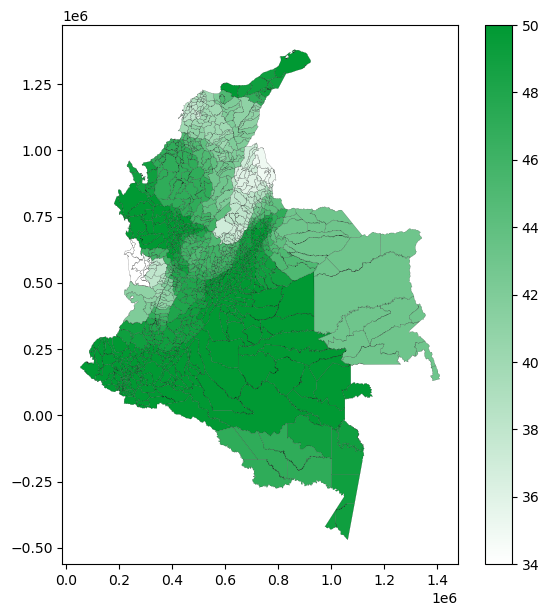

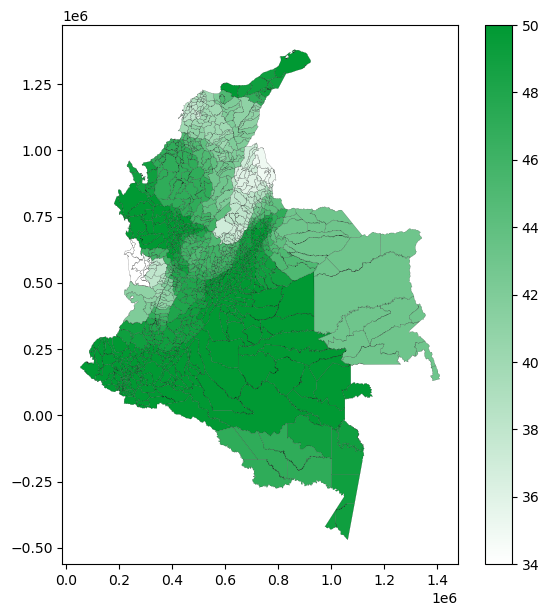

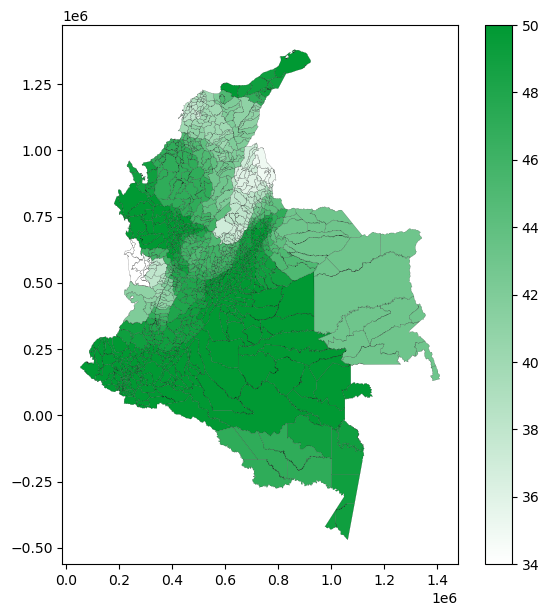

In [61]:
for blm_mult in range(-5, 1):

    blm = 10 * blm_mult
    print(blm)
    change_marxan_parameters(
        wf('mun/input.dat'), {'BLM': blm, 'NUMREPS': 50}
    )
    run_marxan(wf('mun'))
    sol = pd.read_csv(wf('mun/output/output_ssoln.csv')).set_index('planning_unit')
    fig, ax = plt.subplots(figsize=(7, 7))
    mun.join(sol).plot(
        'number',
        ax=ax,
        cmap=my_cmap,
        edgecolor='black',
        linewidth=0.1,
        legend=True
    )

In [ ]:
pu_x_sp = pd.DataFrame(
    index=hexagons.index.rename('pu'),
    columns=municipality.index.rename('cost')
)
